# Setup

In [1]:
# Standard Python libraries
import sys
import random
import string
import os
import math

# Third party libraries
from pylibdmtx.pylibdmtx import encode
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Custom funcs
sys.path.append('../scripts')
from hourglass import *

cuda


## Parameters

In [2]:
input_size = 256 # Input image size for model
output_size = 64 # Output heatmap size for model
n_stacks = 8     # Number of stacks in hourglass model

sigma = 1        # Gaussian distribution (spread) for heatmap generation

n_train = 800    # Number of training samples
n_val = 100      # Number of validation samples
n_test = 100     # Number of test samples

batch_size = 1   # Batch size for training

max_complex_epoch = 150 # Number of epochs where complex data is used

# Calculating weight for loss function
pixels_per_gauss = (5 + 7 + (9*5) + 7 + 5) * 4 # Circles are built from vertical pixels of 5, 7, 9, 9, 9, 9, 9, 7, 5 (and there are 4 of them)
# pixels_per_gauss = 3 + 5 + 5 + 5 + 3 # Circles are built from vertical pixels of 3, 5, 5, 5, 3
pixels_total = 64*64
weight = (pixels_total - pixels_per_gauss) / pixels_per_gauss
print(weight) # There are this many times more background pixels than gaussian pixels

reset_synth = True # Set to True to regenerate synthetic data

13.840579710144928


In [3]:
# Example with 7x7 patch from https://medium.com/towards-data-science/human-pose-estimation-with-stacked-hourglass-network-and-tensorflow-c4e9f84fd3ce
# pixels_per_gauss = 7*7
# pixels_total = 64*64
# weight = (pixels_total - pixels_per_gauss) / pixels_per_gauss
# print(weight) # prints ~82.6

# Data Synthesis

In [4]:
def gen_string():
    '''
    Generates a serial number to encode
    
    Serial numbers are:
    - 11 characters long
    - Index 0, 2, 4, 5, 6, 7, 8, 9, 10 are random digits
    - Index 1 and 3 are uppercase letters
    - Index 11, 12, 13, 14 are an incremental number starting from 0001

    Example serial number: 4 L 4 N 0418028 0001
    '''

    to_encode = ''

    # first 11 indexes
    for j in range(11):
        # 1 and 3 are uppercase
        if j in [1, 3]:
            to_encode += random.choice(string.ascii_uppercase)
        else:
            to_encode += str(random.randrange(0, 10))

    # last 4 indexes
    end = str(random.randrange(1, 99))
    if len(end) == 1:
        end = '0' + end
    elif len(end) == 2:
        end = '00' + end
    else:
        end = '000' + end
    to_encode += end

    return to_encode

def encode_image(to_encode, dmc_size):
    '''Creates a PIL image containing DMC encoding of given string'''

    encoded = encode(to_encode.encode('utf8'))
    img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels)

    # upscale image
    img = img.resize((dmc_size, dmc_size), Image.NEAREST)

    return img

def get_corner_coords(img, debug=False):
    '''Returns the coordinates of corners of DMC'''
    padding = 26 # Padding around DMC info zone in pixels (we only want inner modules!)

    raw_coords = [] # Raw pixel coords of dmc corners
    label_info = [] # Line by line label info

    # Get coords of each corner of DMC
    top_left = (padding-1, padding-1)
    top_right = (img.width-padding, padding-1)
    bottom_left = (padding-1, img.height-padding)
    bottom_right = (img.width-padding, img.height-padding)

    # Paint corners red for viz/debug
    if debug:
        img = img.convert('RGB')
        img.putpixel(top_left, (255, 0, 0))
        img.putpixel(top_right, (255, 0, 0))
        img.putpixel(bottom_left, (255, 0, 0))
        img.putpixel(bottom_right, (255, 0, 0))

    # Normalize pixel coords to 0-1
    top_left_norm = [top_left[0] / img.width, top_left[1] / img.height]
    top_right_norm = [top_right[0] / img.width, top_right[1] / img.height]
    bottom_left_norm = [bottom_left[0] / img.width, bottom_left[1] / img.height]
    bottom_right_norm = [bottom_right[0] / img.width, bottom_right[1] / img.height]

    # Add raw coords
    raw_coords.extend([top_left, top_right, bottom_left, bottom_right])

    # Add normalized coords
    label_info.extend([top_left_norm, top_right_norm, bottom_left_norm, bottom_right_norm])

    return raw_coords, label_info, img

def get_heatmaps_basic(img, raw_coords, heatmap_size, debug=False):
    '''Returns "heatmaps" for each corner of DMC, except they are just single points'''
    
    # Create empty heatmaps
    heatmaps = np.zeros((4, heatmap_size, heatmap_size))

    # Create "heatmaps" for each corner
    for i in range(4):
        # Create "heatmap"
        heatmap = np.zeros((heatmap_size, heatmap_size))
        for y in range(img.height):
            for x in range(img.width):
                if x == raw_coords[i][0] and y == raw_coords[i][1]:
                    heatmap[y, x] = 1
        
        # Scale to heatmap_size x heatmap_size
        heatmap = cv2.resize(heatmap, (heatmap_size, heatmap_size))

        # Add heatmap to heatmaps
        heatmaps[i] = heatmap
    
    # Paint heatmaps on image for viz/debug
    if debug:
        # Scale heatmaps to image size
        debug_heatmaps = []
        for i in range(4):
            debug_heatmaps.append(cv2.resize(heatmaps[i], (img.width, img.height)))
        for i in range(4):
            for y in range(img.height):
                for x in range(img.width):
                    if debug_heatmaps[i][y, x] > 0:
                        img.putpixel((x, y), (int(debug_heatmaps[i][y, x] * 255), 0, 0))
    
    return heatmaps

def get_texture_crop(textures_path, size, debug=False):
    '''Gets a random texture image from the given path and returns a random crop'''

    texture = random.choice(os.listdir(textures_path))

    if debug:
        print(texture)

    texture = Image.open(os.path.join(textures_path, texture))

    # get random crop
    transform = v2.Compose([
        v2.RandomCrop((size, size))
    ])
    texture = transform(texture)

    return texture

73_stainless shiny brushed metal texture.jpg


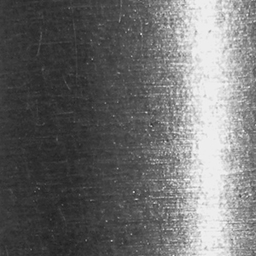

In [5]:
# Testing texture crops (uncomment debug print)
get_texture_crop('../data/textures/', size=input_size, debug=True)

[(25, 25), (230, 25), (25, 230), (230, 230)]
[[0.09765625, 0.09765625], [0.8984375, 0.09765625], [0.09765625, 0.8984375], [0.8984375, 0.8984375]]
(4, 256, 256)
(256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


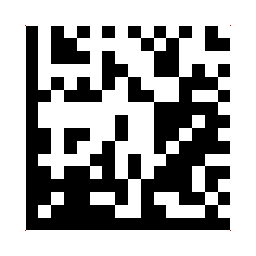

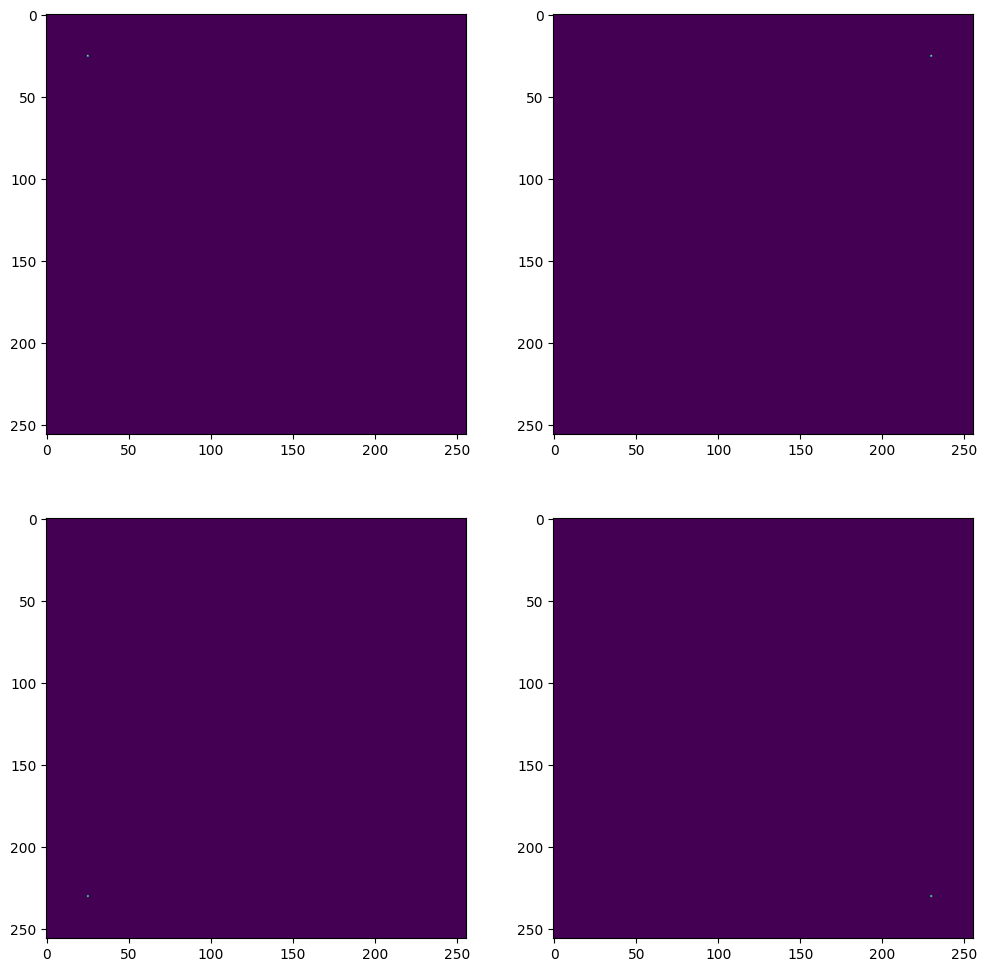

In [6]:
# Testing functions
test = gen_string()
img = encode_image(test, dmc_size=input_size)
raw_coords, label_info, img = get_corner_coords(img, debug=True)
print(raw_coords)
print(label_info)
# heatmaps = get_heatmaps(img, raw_coords, heatmap_size=input_size, sigma=sigma, debug=True)
heatmaps = get_heatmaps_basic(img, raw_coords, heatmap_size=input_size, debug=True)
print(heatmaps.shape)
print(heatmaps[0].shape)
print(heatmaps[0])

# Display image
display(img)

# Display heatmaps
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    heatmap = heatmaps[i]
    # scale up to input size
    heatmap = cv2.resize(heatmap, (input_size, input_size))
    plt.imshow(heatmap)
plt.show()

In [7]:
def gen_save(type, input_size):
    '''Generates a random serial number, encodes it into a DMC image, and saves it to train/val/test folders'''

    to_encode = gen_string()
    img = encode_image(to_encode, dmc_size=input_size)

    # Get corner values
    raw_coords, label_info, img = get_corner_coords(img)

    # Debug print
    if (0, 0) in raw_coords:
        print(raw_coords)
        error

    # Get heatmaps (basic - single point as we will create the actual heatmaps during augmentation)
    heatmaps = get_heatmaps_basic(img, raw_coords, heatmap_size=input_size, debug=False)

    # Convert heatmaps to tensor
    heatmaps = torch.tensor(heatmaps).float()

    # Normalize image
    img = np.array(img)
    img = img / 255
    img = torch.tensor(img).float()
    img = img.permute(2, 0, 1) # Change to having channel dim first

    # Generate random texture crop (size should match input for model)
    texture = get_texture_crop('../data/textures/', size=input_size)

    # Normalize texture
    texture = np.array(texture)
    texture = texture / 255
    texture = torch.tensor(texture).float()
    texture = texture.permute(2, 0, 1) # Change to having channel dim first

    # Combine image, texture, and heatmaps into single tensor
    img = torch.cat((img, texture, heatmaps), dim=0)

    # Save image texture heatmaps wombo combo
    torch.save(img, f'../data/hourglass_localization_rectification/{type}/{to_encode}.pt')

    return

def delete_old():
    '''Deletes all images and labels in train/val/test folders'''

    for folder in ['train', 'val', 'test']:
        for file in os.listdir(f'../data/hourglass_localization_rectification/{folder}'):
            os.remove(f'../data/hourglass_localization_rectification/{folder}/{file}')

    return

In [8]:
# Delete old synth data
if reset_synth:
    delete_old()

In [9]:
# Generating train/val/test datasets
print(f'Generating {n_train} train images...')
for i in range(n_train - len(os.listdir('../data/hourglass_localization_rectification/train'))):
    gen_save('train', input_size=input_size)

print(f'Generating {n_val} val images...')
for i in range(n_val - len(os.listdir('../data/hourglass_localization_rectification/val'))):
    gen_save('val', input_size=input_size)

print(f'Generating {n_test} test images...')
for i in range(n_test - len(os.listdir('../data/hourglass_localization_rectification/test'))):
    gen_save('test', input_size=input_size)

Generating 800 train images...
Generating 100 val images...
Generating 100 test images...


In [10]:
# Test file
def load_test_file():
    '''Loads a test file for inspection'''

    test_file = '../data/hourglass_localization_rectification/train/' + os.listdir('../data/hourglass_localization_rectification/train')[0]
    test_tensor = torch.load(test_file)

    print(test_file)
    return test_tensor
load_test_file()

../data/hourglass_localization_rectification/train/0A1S66167760068.pt


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

../data/hourglass_localization_rectification/train/0A1S66167760068.pt


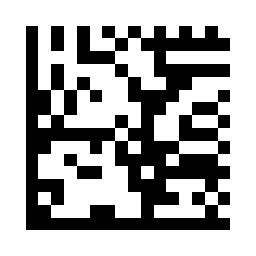

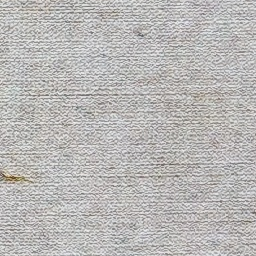

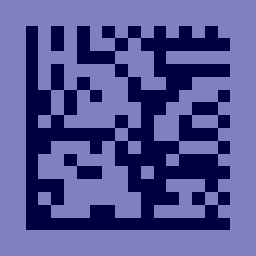

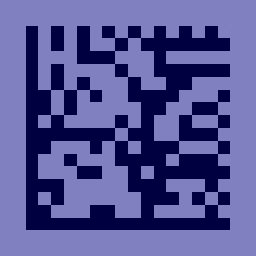

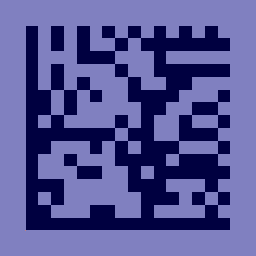

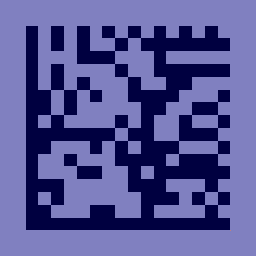

In [11]:
# Helper for presenting images / creating PIL images
def tensors2PIL(tensor, size, debug=False):
    # Move to CPU
    tensor = tensor.cpu()

    # Split into DMC and texture images
    dmc = tensor[:3].numpy()
    texture = tensor[3:6].numpy()
    heatmap = tensor[6:].numpy()

    # Multiply by 255 to convert to 0-255 range
    dmc = dmc * 255
    texture = texture * 255

    # Ensure no values are above 255
    dmc[dmc > 255] = 255
    texture[texture > 255] = 255

    # Convert to uint8
    dmc = dmc.astype(np.uint8)
    texture = texture.astype(np.uint8)

    # Reshape dmc to 3D
    dmc = dmc.reshape(3, size, size).transpose(1, 2, 0)

    # Reshape texture to 3D
    texture = texture.reshape(3, size, size).transpose(1, 2, 0)

    # Reshape heatmaps to 2D
    heatmaps = []
    for i in range(4):
        heatmaps.append(heatmap[i].reshape(size, size))

    # Convert to PIL images
    dmc = Image.fromarray(dmc).convert('L')
    texture = Image.fromarray(texture).convert('RGB')
    for idx, heatmap in enumerate(heatmaps):
        heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Apply color map
        dmc_tmp = cv2.cvtColor(np.array(dmc), cv2.COLOR_GRAY2RGB)
        overlay = cv2.addWeighted(dmc_tmp, 0.5, heatmap_colored, 0.5, 0) # Blend images
        heatmap_img = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        heatmaps[idx] = Image.fromarray(heatmap_img)

    if debug:
        display(dmc)
        display(texture)
        for heatmap in heatmaps:
            display(heatmap)

    return dmc, texture, heatmaps

test_tensor = load_test_file()
dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A1S66167760068.pt
(0.8, 1.2)
(0.2, 0.2)


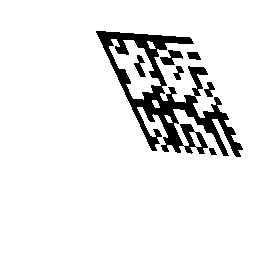

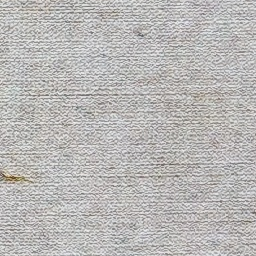

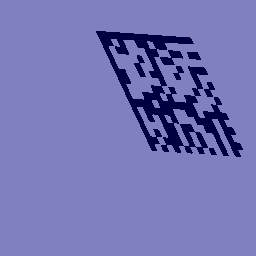

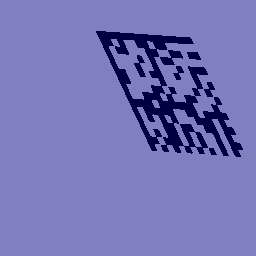

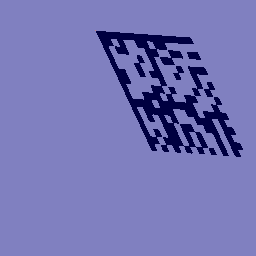

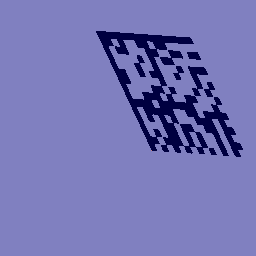

In [12]:
def flood_fill(tensor_image, x, y):
    '''Finds and fills all connected black pixels in image starting from x, y'''
    rows, cols = tensor_image.shape[-2], tensor_image.shape[-1]
    visited = set()
    stack = [(x, y)]

    connected_pixels = []

    while stack:
        cx, cy = stack.pop()
        if (cx, cy) in visited:
            continue
        visited.add((cx, cy))

        # Ensure it's within bounds and is black
        if 0 <= cx < rows and 0 <= cy < cols and tensor_image[cx, cy] == 0:
            connected_pixels.append((cx, cy))

            # Add neighbors (if not at the edge of the image)
            if cx > 0:
                stack.append((cx-1, cy))
            if cx < rows-1:
                stack.append((cx+1, cy))
            if cy > 0:
                stack.append((cx, cy-1))
            if cy < cols-1:
                stack.append((cx, cy+1))

    for idx in connected_pixels:
        tensor_image[idx[0], idx[1]] = 1

    return tensor_image

def shape_transform(tensor, training_mode=False, epoch=None, max_complex_epoch=max_complex_epoch, debug=False):
    '''Applies random shape transformations to image'''
    generation_error = False

    # Split into DMC and heatmaps
    dmc = tensor[:3]
    heatmaps = tensor[6:]

    # Temporarily downsize dmc to 1 channel to allow for next steps (IMPORTANT: THIS WILL SUCK IF SHAPE TRANSFORM SOMEHOW GETS USED AFTER COLOR TRANSFORM)
    dmc = dmc[0]

    # Stacking tensors for easier processing
    batched = torch.stack((dmc, heatmaps[0], heatmaps[1], heatmaps[2], heatmaps[3]), dim=0)

    # First pad batched tensor to ensure corners are not near the edge
    batched = v2.functional.pad(batched, padding=100, fill=0, padding_mode='constant')

    # DEBUG
    heatmaps = batched[1:]
    for i in range(4):
        brightest = heatmaps[i].max()
        torch_mask = torch.where(heatmaps[i] == brightest, torch.tensor(1.0), torch.tensor(0.0))
        if generation_error == False and torch_mask.nonzero()[0].tolist() == [0, 0]:
            print('generation_error - before transforms')
            generation_error = True
        heatmaps[i] = torch_mask

    # Defining max scale and translations
    max_scale = (0.8, 1.2)
    max_translate = (0.2, 0.2)

    if training_mode:
        # Calculate scale and translate amount based on epoch
        if epoch < 10:
            scale = (1, 1)
            translate = (0, 0)
        # Increase scale and translate amount linearly from 10 to max_epoch
        elif epoch < max_complex_epoch:
            scale = 1 + (max_scale[1] - 1) * ((epoch - 10) / (max_complex_epoch - 10))
            scale = (1-scale + 1, scale)
            translate = max_translate[1] * ((epoch - 10) / (max_complex_epoch - 10))
            translate = (translate, translate)
        # After max_epoch, keep at max values
        else:
            scale = max_scale
            translate = max_translate
    else:
        # If not in training mode, just use max values
        scale = max_scale
        translate = max_translate

    if debug:
        print(scale)
        print(translate)

    # Applying transformations to all tensors
    transforms = v2.Compose([
        v2.RandomRotation(180, # Random rotation (-180 to 180 degrees, so full rotation)
                          interpolation=Image.BILINEAR,
                          expand=True),
        v2.RandomPerspective(distortion_scale=0.5,
                             p=0.5,
                             interpolation=Image.BILINEAR,
                             ),
        v2.RandomAffine(degrees=0, # No rotation
                        shear=(-20, 20, -20, 20), # Random shear on x and y axis (squish)
                        interpolation=Image.BILINEAR,
                        scale=scale, # Random scaling (zoom in/out)
                        translate=translate, # Random translation (move dmc around a bit)
                        ),
    ])
    batched = transforms(batched)

    # Resize all to original size
    dmc_width, dmc_height = dmc.shape[-1], dmc.shape[-2]
    batched = v2.functional.resize(batched, (dmc_height, dmc_width), interpolation=Image.BILINEAR)

    # Binarize dmc
    dmc = batched[0]
    dmc = torch.where(dmc > 0.5, torch.tensor(1.0), torch.tensor(0.0))

    # DEBUG
    heatmaps = batched[1:]
    for i in range(4):
        brightest = heatmaps[i].max()
        torch_mask = torch.where(heatmaps[i] == brightest, torch.tensor(1.0), torch.tensor(0.0))
        if generation_error == False and torch_mask.nonzero()[0].tolist() == [0, 0]:
            # print('generation_error - after transforms')
            generation_error = True
        heatmaps[i] = torch_mask

    # Fill outer black areas of dmc with white
    dmc = flood_fill(dmc, 0, 0)
    dmc = flood_fill(dmc, 0, dmc.shape[-1]-1)
    dmc = flood_fill(dmc, dmc.shape[-2]-1, 0)
    dmc = flood_fill(dmc, dmc.shape[-2]-1, dmc.shape[-1]-1)

    # Split back into DMC and heatmaps
    dmc = dmc.unsqueeze(0)
    heatmaps = batched[1:]

    # Binarize heatmaps so that brightest pixel is 1 and rest are 0
    for i in range(4):
        brightest = heatmaps[i].max()
        torch_mask = torch.where(heatmaps[i] == brightest, torch.tensor(1.0), torch.tensor(0.0))
        if generation_error == False and torch_mask.nonzero()[0].tolist() == [0, 0]:
            print('generation_error - after paintbucket')
        heatmaps[i] = torch_mask

    # Add back color channels to DMC
    dmc = torch.cat((dmc, dmc, dmc), dim=0)

    return dmc, heatmaps, generation_error

test_tensor = load_test_file()
test_tensor[:3], test_tensor[6:], generation_error = shape_transform(test_tensor, training_mode=True, epoch=150, max_complex_epoch=max_complex_epoch, debug=True)
dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A1S66167760068.pt


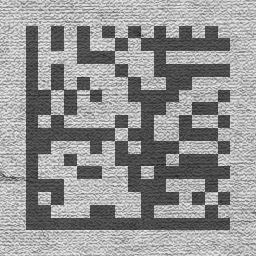

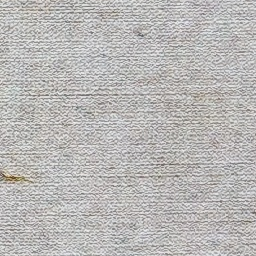

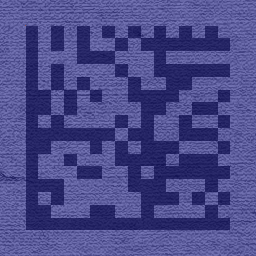

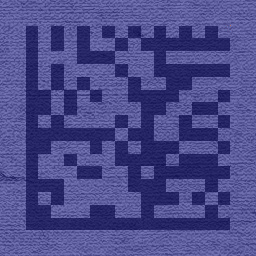

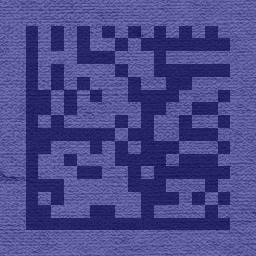

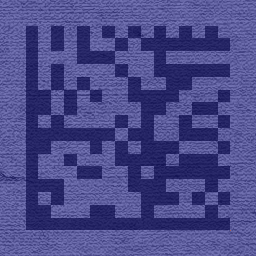

In [13]:
def combine_images(tensor):
    '''Combines DMC and texture tensors into one tensor'''
    dmc = tensor[:3].unsqueeze(0)
    texture = tensor[3:6].unsqueeze(0)

    # Increment black pixel intensity of DMC randomly
    increment = random.uniform(0.1, 0.5)
    dmc = torch.where(dmc < 0.5, dmc + increment, dmc)

    # Multiply DMC onto each texture channel
    texture = torch.mul(texture, dmc)

    # Remove batch dimension
    texture = texture.squeeze(0)

    return texture

test_tensor = load_test_file()
test_tensor[:3] = combine_images(test_tensor)
combined_dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A1S66167760068.pt


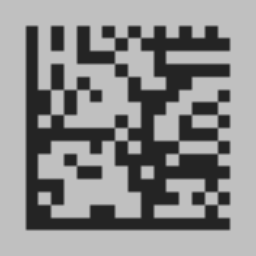

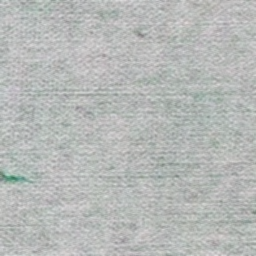

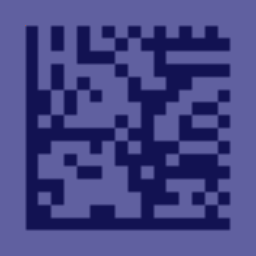

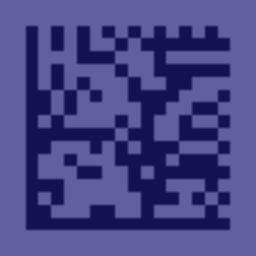

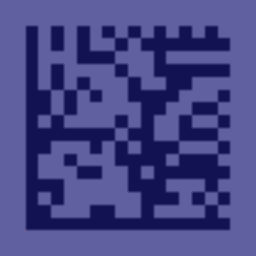

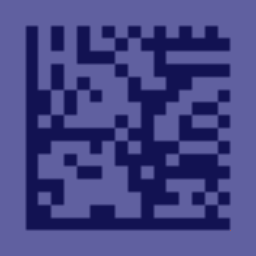

In [14]:
def color_transform(tensor):
    '''Applies random color transformations to image'''

    # Unsqueeze tensor to add batch dimension
    tensor = tensor.unsqueeze(0)

    # Random kernel size for gaussian blur
    kernel_size = random.choice([3, 5])
    sharpness = random.uniform(0.5, 1.5)

    transforms = v2.Compose([
        # v2.ColorJitter(brightness = (0.5, 1.5),
        #                contrast   = (0.5, 1.5),
        #                saturation = (0.5, 1.5),
        #                hue        = (-0.5, 0.5),
        #                ),
        # v2.RandomChannelPermutation(),
        v2.RandomPhotometricDistort(brightness = (0.5, 1.5),
                                    contrast   = (0.5, 1.5),
                                    saturation = (0.5, 1.5),
                                    hue        = (-0.5, 0.5),
                                    ),
        v2.GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 25)), # chance to blur a lot or a little - mostly an ok amount
        # v2.GaussianNoise(), # not implemented for PIL images
        # v2.RandomInvert(0.2), # lower chance of inversion # apply to code not background
        # v2.RandomPosterize(8),
        # v2.RandomSolarize(0.5, 0.5),
        v2.RandomAdjustSharpness(sharpness, 0.5),
        # v2.RandomAutocontrast(),
        # v2.RandomEqualize(0.2), # lower chance of equalization
    ])

    # Dummy transform for testing
    # transforms = v2.Compose([
    #     v2.Pad(padding=0)
    # ])

    tensor = transforms(tensor)

    # Remove batch dimension
    tensor = tensor.squeeze(0)

    return tensor

# Testing color_transform
test_tensor = load_test_file()
test_tensor[:3] = color_transform(test_tensor[:3])
test_tensor[3:6] = color_transform(test_tensor[3:6])
dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

../data/hourglass_localization_rectification/train/0A1S66167760068.pt
DMC TEXTURE PAIR
SHAPE TRANSFORM
(0.8, 1.2)
(0.2, 0.2)
COMBINE IMAGES
COLOR TRANSFORM
FINAL SIZES
torch.Size([3, 256, 256])
torch.Size([4, 256, 256])


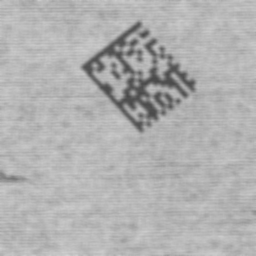

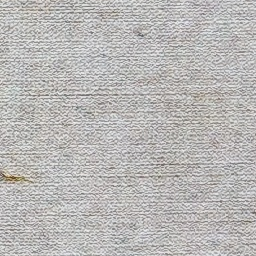

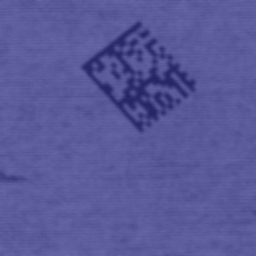

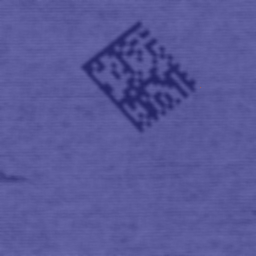

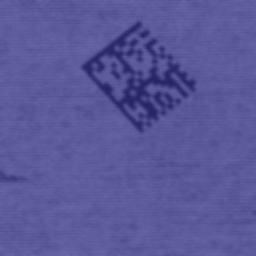

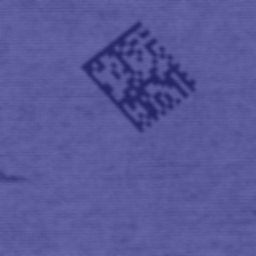

In [15]:
# Testing all transforms
test_tensor = load_test_file()

print('DMC TEXTURE PAIR')
# dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

print('SHAPE TRANSFORM')
test_tensor[:3], test_tensor[6:], generation_error = shape_transform(test_tensor, training_mode=False, debug=True)
# dmc, texture, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

if generation_error:
    print('GENERATION ERROR')

print('COMBINE IMAGES')
dmc = combine_images(test_tensor)
# dmc_img, texture_img, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

print('COLOR TRANSFORM')
dmc = color_transform(dmc)

# Overwrite for the sake of seeing
test_tensor[:3] = dmc
print('FINAL SIZES')
print(dmc.shape)
print(test_tensor[6:].shape)
dmc_img, texture_img, heatmaps = tensors2PIL(test_tensor, size=input_size, debug=True)

In [16]:
# Helper function for resizing heatmaps
def resize_heatmaps(heatmaps, size):
    '''Resizes heatmaps to given size'''
    new_heatmaps = np.zeros((4, size, size))
    for i in range(4):
        # Find proportionally where the max value is in the heatmap
        y, x = np.unravel_index(np.argmax(heatmaps[i].cpu().numpy()), heatmaps[i].shape)
        y = int(y * size / heatmaps[i].shape[0])
        x = int(x * size / heatmaps[i].shape[1])

        # Create new heatmap
        heatmap = np.zeros((size, size))
        heatmap[y, x] = 1

        new_heatmaps[i] = heatmap

    # Convert to tensor
    new_heatmaps = torch.tensor(new_heatmaps).float()

    return new_heatmaps

# Actually creating the heatmaps from the pixel heatmaps
def create_heatmap(heatmaps, size, sigma):
    '''Creates heatmaps from pixel heatmaps'''
    heatmap = np.zeros((size, size))
    for pixel_heatmap in heatmaps:
        # Center of keypoint
        y, x = np.unravel_index(np.argmax(pixel_heatmap.cpu().numpy()), pixel_heatmap.shape)

        # Fill heatmap with gaussian distribution (keeping only 95% of the distribution)
        threshold = 0.05
        for y2 in range(size):
            for x2 in range(size):
                value = np.exp(-((x2 - x)**2 + (y2 - y)**2) / (2 * sigma**2))  # Sigma = std of the Gaussian distribution
                if value >= threshold:
                    heatmap[y2, x2] = value

    # Convert to tensor
    heatmap = torch.tensor(heatmap).float()

    return heatmap

torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 64])
0 generation errors


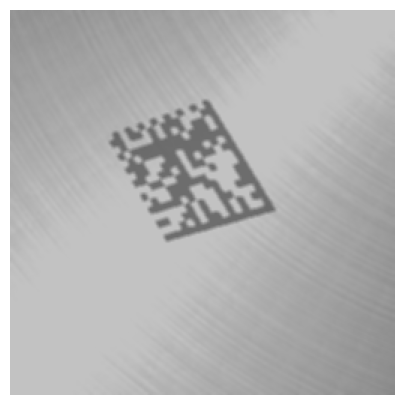

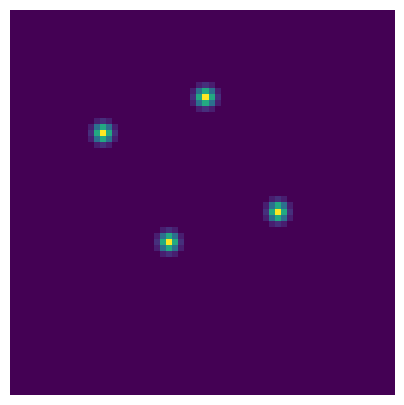

In [ ]:
# Dataloader
class DMCDataset(Dataset):
    def __init__(self, image_dir, training_mode=False, epoch=None, max_complex_epoch=max_complex_epoch):
        self.image_dir = image_dir
        self.files = os.listdir(image_dir)
        self.training_mode = training_mode
        self.epoch = epoch
        self.max_complex_epoch = max_complex_epoch

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self, idx):
        # Shape transform dmc and heatmaps
        generation_error = True
        count = 0
        while generation_error == True:
            # if count > 0:
            #     print('Trying again...')

            # Load the tensor containing dmc, texture, and heatmaps
            tensor = torch.load(f'{self.image_dir}/{self.files[idx]}')
            tensor[:3], tensor[6:], generation_error = shape_transform(tensor, training_mode=self.training_mode, epoch=self.epoch, max_complex_epoch=self.max_complex_epoch)
            count += 1
        # if count > 1:
        #     print('Fixed!')

        # Combine dmc and texture pair
        dmc = combine_images(tensor)

        # Color transform dmc
        dmc = color_transform(dmc)

        # Resize pixel heatmaps to output size
        heatmaps = resize_heatmaps(tensor[6:], output_size)

        # Create actual heatmaps from binarized heatmaps
        heatmap = create_heatmap(heatmaps, output_size, sigma)

        return dmc, heatmap, count

def define_train_loader(epoch):
    train_dataset = DMCDataset(
        image_dir='../data/hourglass_localization_rectification/train',
        training_mode=True,
        epoch=epoch,
        max_complex_epoch=max_complex_epoch,
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    return train_loader

train_loader = define_train_loader(epoch=0)

# Testing dataloader
for dmc, heatmap, count in train_loader:
    print(dmc.shape)
    print(heatmap.shape)
    print(f'{count.item()-1} generation errors')

    # Display dmc and heatmap
    plt.figure(figsize=(5, 5))
    plt.axis('Off')
    plt.imshow(dmc.squeeze(0).permute(1, 2, 0))
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.axis('Off')
    plt.imshow(heatmap.squeeze(0))
    plt.show()
    break

In [18]:
val_dataset = DMCDataset(
    image_dir='../data/hourglass_localization_rectification/val',
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataset = DMCDataset(
    image_dir='../data/hourglass_localization_rectification/test',
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

# Stacked Hourglass Setup

In [19]:
# Example usage with dataloader
model = StackedHourglassNetwork(
    num_stacks=n_stacks,
    num_features=input_size,
    num_output_points=1,
)

for images, heatmaps, count in train_loader:
    print(images.shape)
    print(heatmaps.shape)
    print(f'{count.item()-1} generation errors')
    outputs = model(images)
    for output in outputs:
        print(output.shape) # Expected: (8, 1, H, W) representing 1 heatmap per image
    break
print(output)

torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 64])
0 generation errors
torch.Size([8, 1, 64, 64])
tensor([[[[ -13.0925,  -13.0942,  -14.8194,  ...,   -8.4549,   -7.8103,
             -8.5799],
          [ -12.5891,  -12.5222,  -13.7713,  ...,   -6.9260,   -6.6492,
             -8.0672],
          [ -13.6222,  -14.6057,  -10.5971,  ...,   -5.1755,   -6.0696,
             -6.6514],
          ...,
          [ -11.6020,  -12.3057,  -12.0772,  ...,  -12.6123,  -13.6209,
            -13.8344],
          [ -10.1931,  -11.2949,  -10.9021,  ...,  -12.1856,  -11.4367,
            -12.2013],
          [  -9.9571,  -11.3373,  -11.5292,  ...,  -12.2038,  -12.8935,
            -12.3891]]],


        [[[  19.0670,   19.5390,   20.5306,  ...,   14.4639,   13.5934,
             12.9026],
          [  18.2984,   19.6766,   20.5020,  ...,   14.9860,   14.0670,
             12.9471],
          [  16.4324,   19.3702,   22.3601,  ...,   14.8468,   13.4610,
             12.3633],
          ...,
          [

(64, 64)


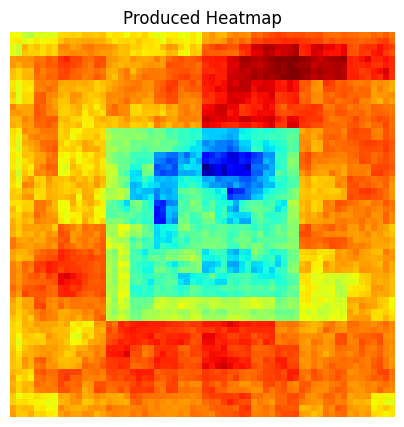

In [20]:
# Convert tensor to numpy for visualization
heatmap = output[0, 0].detach().cpu().numpy()  # Shape: (1, H, W)
print(heatmap.shape)

plt.figure(figsize=(5, 5))
plt.imshow(heatmap, cmap='jet')
plt.title('Produced Heatmap')
plt.axis('off')

plt.show()

In [21]:
def extract_keypoints(heatmap, input_size, output_size):
    heatmap = heatmap.copy() # Don't modify original heatmap

    scale = input_size / output_size  # Scale factor to match original resolution
    keypoints = []

    # Find 4 brightest points in heatmap
    for _ in range(4):
        y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        keypoints.append((int(x * scale), int(y * scale))) # Scale keypoints
        heatmap[y, x] = 0 # Remove brightest point to find next brightest point

    return keypoints

def heatmap_viz(image, keypoints, heatmap, alpha=0.5):
    # Combined figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image with keypoints
    image_kp = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert for OpenCV
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)] # Colors are blue, green, red, yellow (BGR)
    for i, (x, y) in enumerate(keypoints):
        cv2.circle(image_kp, (x, y), 5, colors[i], -1)  # Draw colored circle
    axes[0].imshow(cv2.cvtColor(image_kp, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Heatmaps
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to input image size
    heatmap_resized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_resized.min())  # Normalize
    heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Apply color map
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)  # Blend images
    axes[1].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axes[1].axis('off')
    axes[1].set_title('Heatmap')

    plt.show()

(64, 64)
Predicted keypoints: [(128, 196), (132, 196), (124, 200), (0, 244)]


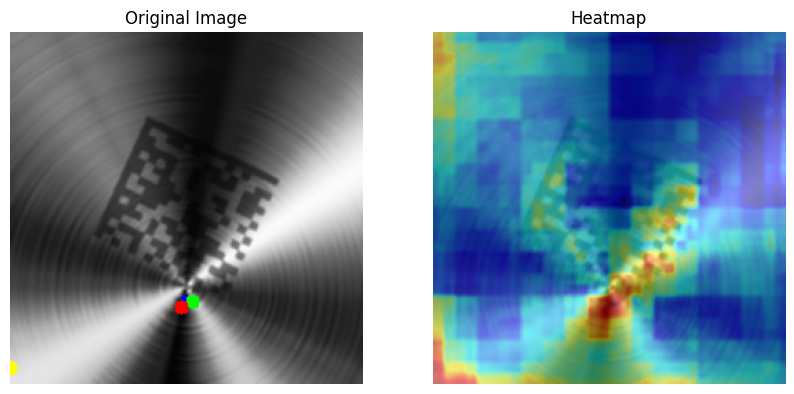

In [22]:
# Example vizualization usage with dataloader
model = StackedHourglassNetwork(
    num_stacks=n_stacks,
    num_features=input_size,
    num_output_points=1,
)

for images, labels, count in train_loader:
    outputs = model(images)
    break

heatmaps = outputs[0][0][0].detach().cpu().numpy() # Convert tensor to numpy
print(heatmaps.shape)
keypoints = extract_keypoints(heatmaps, input_size=input_size, output_size=output_size)
print('Predicted keypoints:', keypoints)

img = images[0].permute(1, 2, 0).numpy() * 255
img = img.astype(np.uint8) # Convert to ints only
heatmap_viz(img, keypoints, heatmaps)

(64, 64)
True keypoints: [(104, 68), (180, 116), (72, 136), (148, 184)]


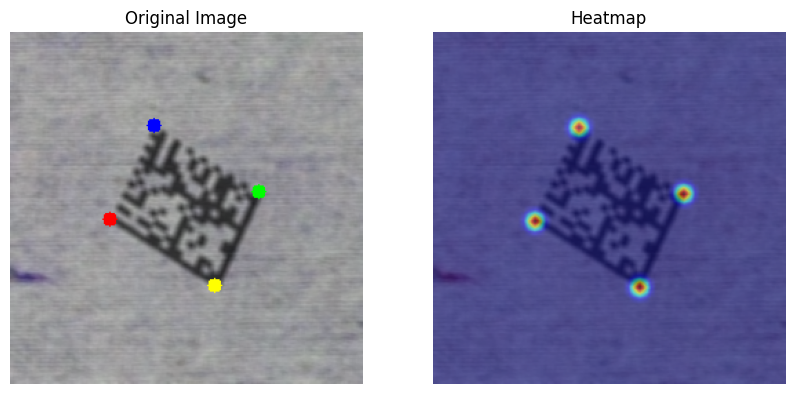

In [23]:
# Example vizualization of true keypoints and heatmaps
for images, labels, count in train_loader:
    for i in range(images.shape[0]):
        image = images[i].permute(1, 2, 0).numpy() * 255
        image = image.astype(np.uint8) # Convert to ints only

        heatmaps = labels[i].detach().cpu().numpy()  # Convert tensor to numpy
        print(heatmaps.shape)
        keypoints = extract_keypoints(heatmaps, input_size=input_size, output_size=output_size)
        print('True keypoints:', keypoints)
        heatmap_viz(image, keypoints, heatmaps)
    break

# Model Training

In [25]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [27]:
def calculate_loss(outputs, heatmap):
    '''Calculates the loss between predicted and target heatmaps'''

    # outputs dims: (batch_size, num_stacks, num_keypoints, H, W)
    # heatmaps dims: (batch_size, num_keypoints, H, W)

    # Remove batch dims
    outputs = outputs.squeeze(0) # Now dims: (num_stacks, num_keypoints, H, W)
    heatmap = heatmap.squeeze(0) # Now dims: (num_keypoints, H, W)

    # Calculate loss for each stack
    weights = (heatmap > 0).float() * weight + 1 # Weighted loss (1 for pixels not part of gaussian, gaussian pixel value * weight for pixels part of gaussian)
    loss = 0
    for i in range(outputs.shape[0]):
        loss += torch.mean((heatmap - outputs[i])**2 * weights) # Accumulate loss over each stack and ground truth (weighted version)

    return loss

In [27]:
# Output and Heatmaps with circle in the middle
outputs = torch.zeros((batch_size, n_stacks, 1, 64, 64), device=device)
outputs[:, :, :, 32, 32] = 0
heatmaps = torch.zeros((batch_size, 1, 64, 64), device=device)
heatmaps[:, :, 32, 32] = 1

# Calculate loss
print(f'outputs from model: {outputs.shape}')
print(f'heatmaps pre loss: {heatmaps.shape}')
loss = calculate_loss(outputs, heatmaps)
print(loss)

outputs from model: torch.Size([1, 8, 1, 64, 64])
heatmaps pre loss: torch.Size([1, 1, 64, 64])
tensor(0.0290, device='cuda:0')


In [28]:
# Training function
def train_model(model, early_stopper, train_loader, val_loader, epochs=10, lr=0.001):
    model.to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    losses = {'train': [], 'val': []} # Store losses

    lowest_val_loss = float('inf')
    best_epoch = 0
    generation_errors = 0

    for epoch in range(epochs):
        model.train()

        train_loader = define_train_loader(epoch)

        train_loss = 0
        for images, heatmaps, count in train_loader:
            images, heatmaps = images.to(device), heatmaps.to(device)

            # Add generation errros
            generation_errors += count.item()-1

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Custom loss function
            loss = calculate_loss(outputs, heatmaps)

            # Backprop
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        losses['train'].append(train_loss/len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks, _ in val_loader:
                images, masks = images.to(device), masks.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = calculate_loss(outputs, masks)

                val_loss += loss.item()

        losses['val'].append(val_loss/len(val_loader))

        # Keep best model based on validation loss
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict() # Save best model state

        # Early stopping if most complex examples are in and validation loss increases
        if epoch > max_complex_epoch+early_stopper.patience and early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {epoch+1}')
            break

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.5f}, Val Loss: {val_loss/len(val_loader):.5f}')

    print('Best epoch:', best_epoch+1)
    print(f'Total generation errors: {generation_errors}')

    # Reload the best model weights
    model.load_state_dict(best_model_state)

    return model, losses, lowest_val_loss

In [31]:
def fancy_train_model():
    model = StackedHourglassNetwork(
        num_stacks=n_stacks,
        num_features=input_size,
        num_output_points=1,
        )

    print('Initial training...')
    early_stopper = EarlyStopper(patience=20, min_delta=0)
    train_loader = define_train_loader(epoch=0)
    model, losses, lowest_val_loss = train_model(model,
                                                 early_stopper,
                                                 train_loader,
                                                 val_loader,
                                                 epochs=1000,
                                                 lr=2.5e-4 # As in paper
                                                 )

    print('\nReduced LR training...')
    early_stopper = EarlyStopper(patience=20, min_delta=0)
    train_loader = define_train_loader(epoch=max_complex_epoch+1) # Ensuring most complex examples are being used
    model, losses_tmp, lowest_val_loss_tmp = train_model(model,
                                                         early_stopper,
                                                         train_loader,
                                                         val_loader,
                                                         epochs=1000,
                                                         lr=(2.5e-4) / 5 # Reduce by factor 5 (as in paper)
                                                         )
    
    for loss in losses_tmp['train']:
        losses['train'].append(loss)
    for loss in losses_tmp['val']:
        losses['val'].append(loss)

    print('\nTraining complete!')

    return model, losses

In [32]:
# Most recent change: curriculum learning + forced early stopping avoidance until max_complex_epoch
model, losses = fancy_train_model()

Initial training...
Epoch 1/1000, Train Loss: 179903965.54744, Val Loss: 6023.48921
Epoch 2/1000, Train Loss: 2283.68246, Val Loss: 6700.29742
Epoch 3/1000, Train Loss: 1863.42703, Val Loss: 5784.10556
Epoch 4/1000, Train Loss: 1915.88311, Val Loss: 2656.95463
Epoch 5/1000, Train Loss: 1735.27423, Val Loss: 3733.88763
Epoch 6/1000, Train Loss: 4044.63496, Val Loss: 48326.26805
Epoch 7/1000, Train Loss: 2235.85898, Val Loss: 15216.81117
Epoch 8/1000, Train Loss: 2802.89679, Val Loss: 3806.44512
Epoch 9/1000, Train Loss: 4102.85959, Val Loss: 13172.52332
Epoch 10/1000, Train Loss: 1077.78087, Val Loss: 3559.57160
Epoch 11/1000, Train Loss: 2126.75576, Val Loss: 3147.35880
Epoch 12/1000, Train Loss: 2030.84669, Val Loss: 1563.74384
Epoch 13/1000, Train Loss: 2049.77812, Val Loss: 4945.49332
Epoch 14/1000, Train Loss: 1515.58953, Val Loss: 802.75946
Epoch 15/1000, Train Loss: 1196.74545, Val Loss: 4536.95765
Epoch 16/1000, Train Loss: 2218.00391, Val Loss: 756.12712
Epoch 17/1000, Train Lo

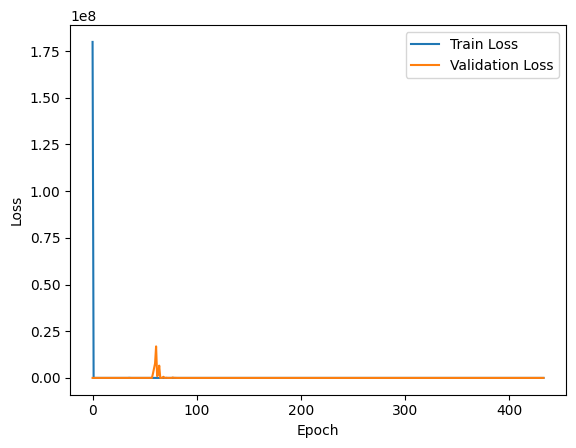

In [33]:
# Show training and validation losses
plt.plot(losses['train'], label='Train Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model, '../models/hourglass_localization_rectification.pth')

# Model Evaluation

In [ ]:
model = torch.load('../models/hourglass_localization_rectification.pth', weights_only=False, map_location=device)

In [25]:
def evaluate_model(model, loader):
    model.eval()

    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for images, heatmaps, _ in loader:
            images, heatmaps = images.to(device), heatmaps.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = calculate_loss(outputs, heatmaps)

            total_loss += loss.item()
            count += 1

    print(f'Total loss: {total_loss:.4f}')
    print(f'Average batch loss: {total_loss/count:.4f}')
    print(f'Average single loss: {total_loss/(count*images.shape[0]):.4f}')

# Normal trained

In [28]:
# Train loss
evaluate_model(model, train_loader)

Total loss: 6.7249
Average batch loss: 0.1345
Average single loss: 0.1345


In [29]:
# Val loss
evaluate_model(model, val_loader)

Total loss: 7.6824
Average batch loss: 0.1600
Average single loss: 0.1600


In [30]:
# Test loss
evaluate_model(model, test_loader)

Total loss: 6.7555
Average batch loss: 0.1379
Average single loss: 0.1379


In [31]:
def compare_keypoints(orig_image, outputs, true_heatmaps):
    '''Compares predicted and true keypoints for a single image'''
    img = orig_image.permute(1, 2, 0).cpu().numpy() * 255
    img = img.astype(np.uint8) # Convert to ints only

    outputs_reshape = outputs[-1][0] # Grab last stack output heatmap 0 (64, 64)

    pred_keypoints = extract_keypoints(outputs_reshape, input_size=input_size, output_size=output_size)
    true_keypoints = extract_keypoints(true_heatmaps, input_size=input_size, output_size=output_size)

    print(f'Predicted keypoints: {pred_keypoints}')
    heatmap_viz(img, pred_keypoints, outputs_reshape)

    print(f'True keypoints: {true_keypoints}')
    heatmap_viz(img, true_keypoints, true_heatmaps)

    return

def compare_hourglass_outputs(orig_image, outputs, true_heatmaps):
    '''Compares heatmaps across all hourglass outputs for a single image'''
    # outputs is a tensor of heatmaps for each hourglass output, with dims (num_stacks, 1, 64, 64)
    # true_heatmaps is the true heatmaps for the image (64, 64)
    
    # Display combined heatmaps
    fig, axes = plt.subplots(1, len(outputs)+2, figsize=(20, 5))

    # Display original image
    dmc_image = orig_image.permute(1, 2, 0).cpu().numpy() * 255
    dmc_image = dmc_image.astype(np.uint8) # Convert to ints only
    axes[0].imshow(dmc_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display each hourglass output
    for i in range(len(outputs)):
        axes[i+1].imshow(outputs[i][0], cmap='jet')
        axes[i+1].set_title(f'Hourglass {i+1}')
        axes[i+1].axis('off')

    # Display true heatmap
    axes[-1].imshow(true_heatmaps, cmap='jet')
    axes[-1].set_title('True Heatmap')
    axes[-1].axis('off')

    # Show plot
    plt.show()

def print_single_result(model, loader):
    model.eval()

    with torch.no_grad():
        for images, true_heatmaps, _ in loader:
            image, true_heatmaps = images.to(device)[0], true_heatmaps.numpy()[0]
            # image shape: (3, 256, 256)
            # true_heatmaps shape: (64, 64)
            break

        # Convert image
        dmc_image = image.permute(1, 2, 0).cpu().numpy() * 255
        dmc_image = dmc_image.astype(np.uint8) # Convert to ints only

        # Single image forward pass
        images = image.unsqueeze(0)
        outputs = model(images)
        outputs = outputs[0].detach().cpu().numpy() # Grab first batch (8, 1, 64, 64)

        compare_keypoints(image, outputs, true_heatmaps)
        compare_hourglass_outputs(image, outputs, true_heatmaps)

## Train Print

Predicted keypoints: [(136, 96), (184, 124), (156, 180), (156, 176)]


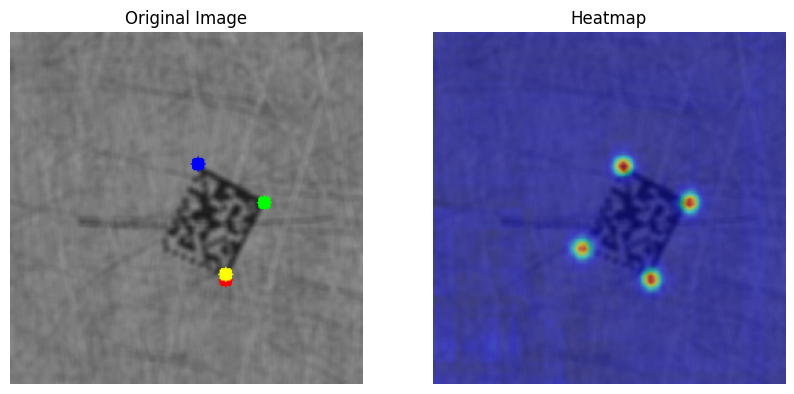

True keypoints: [(136, 96), (184, 120), (104, 156), (156, 176)]


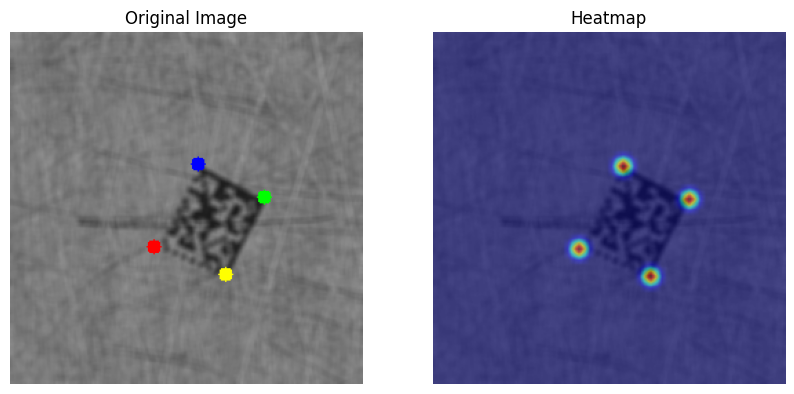

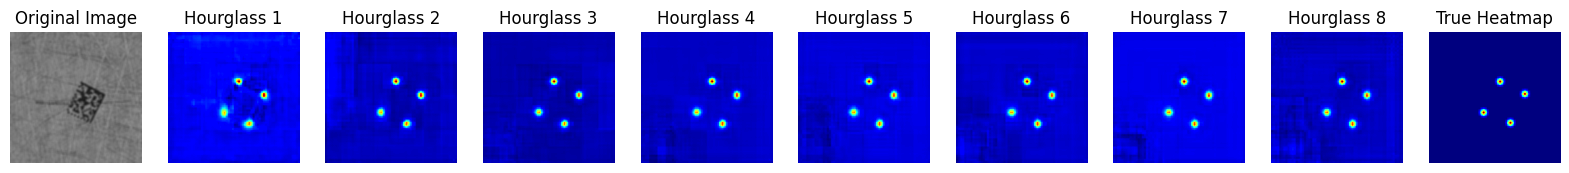

In [32]:
print_single_result(model, train_loader)

## Validation Print

Predicted keypoints: [(92, 156), (60, 68), (56, 68), (96, 156)]


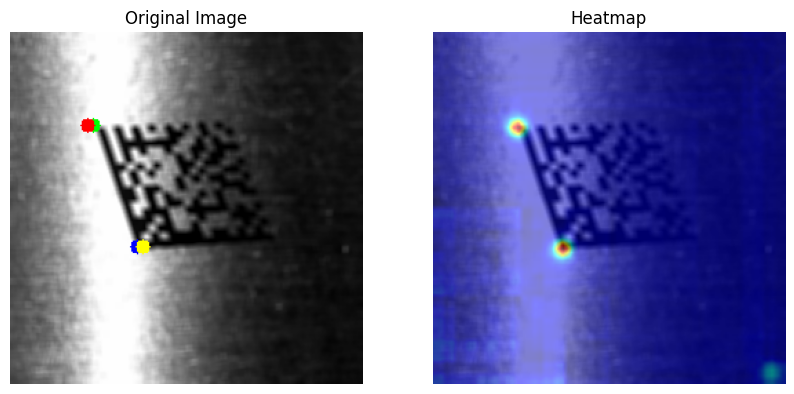

True keypoints: [(156, 64), (60, 68), (192, 152), (92, 156)]


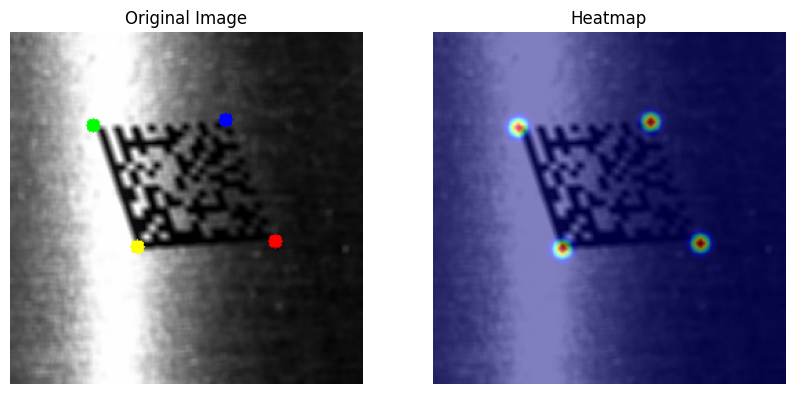

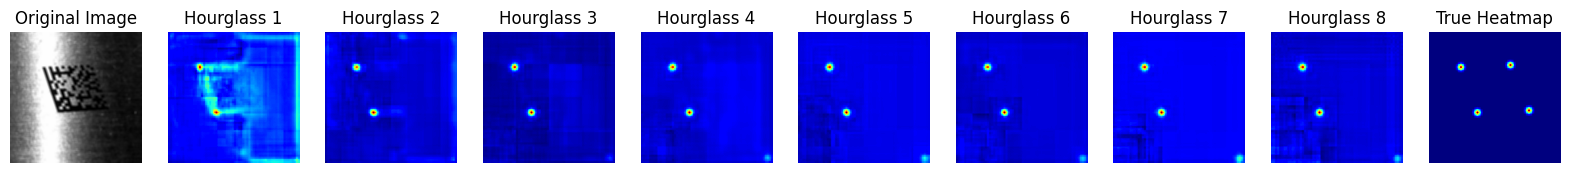

In [33]:
print_single_result(model, val_loader)

## Test Print

Predicted keypoints: [(108, 168), (116, 60), (216, 168), (116, 56)]


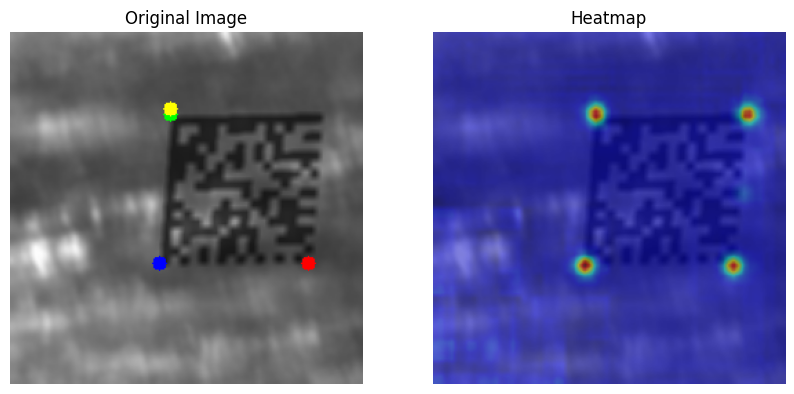

True keypoints: [(224, 56), (116, 60), (108, 168), (216, 168)]


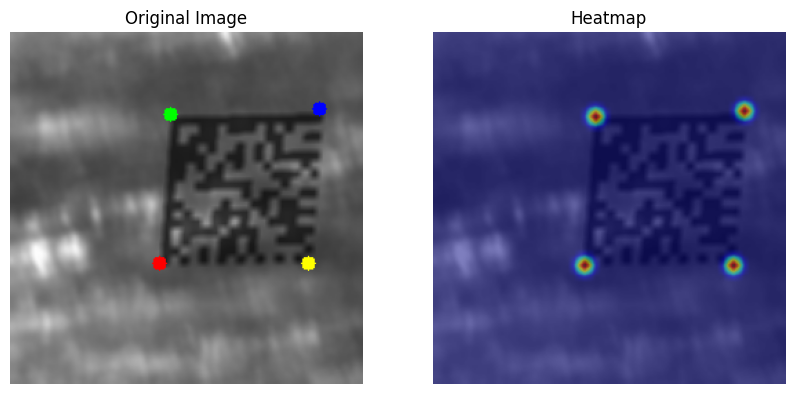

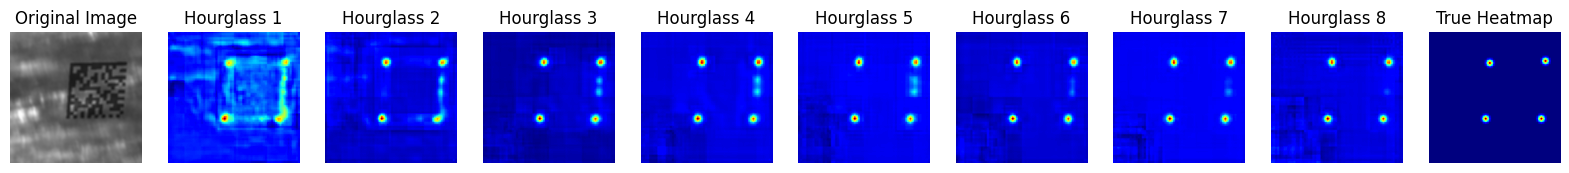

In [34]:
print_single_result(model, test_loader)

# Model Testing on MAN Data

In [36]:
model = torch.load('../models/hourglass_localization_rectification.pth', weights_only=False, map_location=device)

In [157]:
# Dataloader
class MANDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.label_dir = label_dir
        self.label_files = os.listdir(label_dir)

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self, idx):
        # Load the png image
        image = Image.open(f'{self.image_dir}/{self.image_files[idx]}')

        # Convert to tensor
        transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        dmc = transform(image)
        # dmc = v2.functional.to_tensor(image)

        # Resize to input size for model
        dmc = v2.functional.resize(dmc, (input_size, input_size))

        # Load the txt label
        label = np.loadtxt(f'{self.label_dir}/{self.label_files[idx]}')

        # Extract relative coords from label and convert to raw coords
        relative_coords = [(label[5], label[6]), (label[8], label[9]), (label[11], label[12]), (label[14], label[15])]
        raw_coords = []
        for coord in relative_coords:
            raw_coords.append((int(coord[0] * image.width), int(coord[1] * image.height)))

        # Create basic heatmap
        heatmap_basic = get_heatmaps_basic(image, raw_coords, input_size, debug=False)
        heatmap_basic = torch.tensor(heatmap_basic).float()

        # Resize heatmap to output size
        heatmap_basic = v2.functional.resize(heatmap_basic, (output_size, output_size))

        # Create gaussian heatmap from basic heatmap
        heatmap_gaussian = create_heatmap(heatmap_basic, output_size, sigma)

        return dmc, heatmap_gaussian, 0

man_dataset = MANDataset(
    image_dir='../data/MAN/raw/images',
    label_dir='../data/MAN/raw/labels',
)

man_loader = torch.utils.data.DataLoader(
    man_dataset,
    batch_size=batch_size,
    shuffle=True,
)

Predicted keypoints: [(48, 120), (92, 168), (92, 128), (20, 84)]


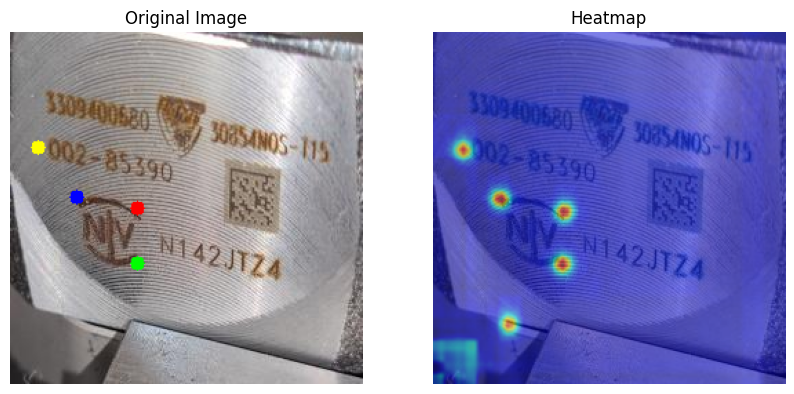

True keypoints: [(156, 96), (192, 104), (156, 132), (188, 140)]


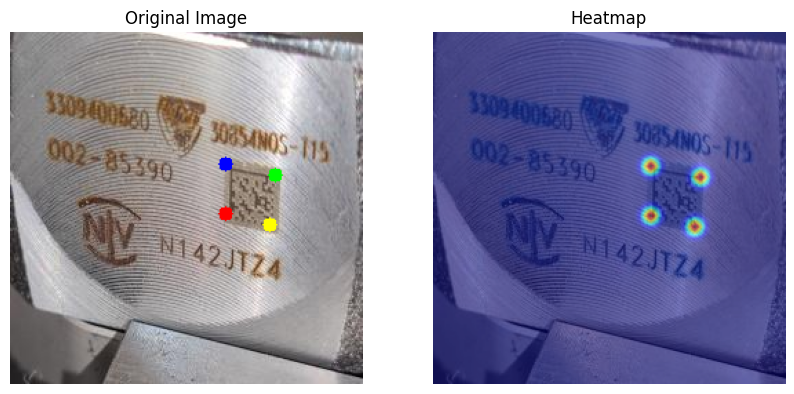

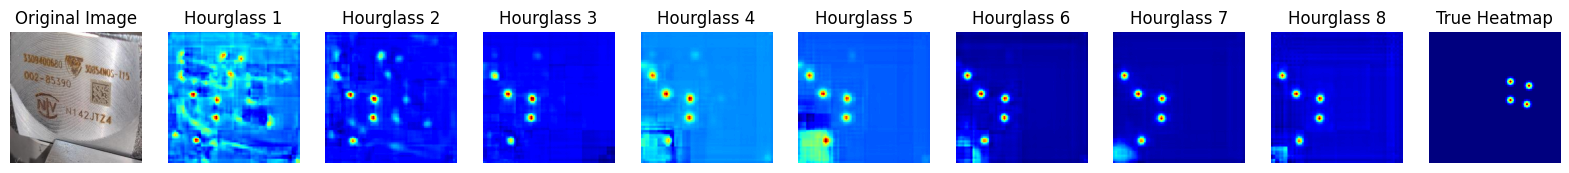

In [162]:
print_single_result(model, man_loader)